In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [2]:
data = pd.read_json("book_chapters_w_NER_sent_readability.jl", lines=True)

In [3]:
comment_periodicity = data[["published","num_comments"]] # these two are the columns we want here 
comment_periodicity.set_index("published", inplace=True) # setting the published date to the index
comment_periodicity.index = pd.to_datetime(comment_periodicity.index) # ensuring the index *is* timestamp
comment_periodicity = comment_periodicity.sort_index() # sorting the timestamps

In [4]:
comment_periodicity

,num_comments
published,
2015-03-25 13:30:12+00:00,46
2015-04-01 20:34:46+00:00,68
2015-04-08 07:00:00+00:00,40
2015-04-16 00:24:48+00:00,29
2015-04-22 18:27:21+00:00,27
...,...
2022-02-12 06:05:00+00:00,200
2022-02-15 06:13:34+00:00,142
2022-02-18 05:55:45+00:00,207


In [5]:
# two goals here -> 1) figure out if there's seasonality and what the trend is here
# 2) detrend the data

### Step 1) Checking to see if there are duplicate timestamps (possible)

In [6]:
comment_periodicity.index.value_counts() # we have duplicates

2018-12-03 05:00:20+00:00    2
2015-03-25 13:30:12+00:00    1
2020-02-18 05:01:22+00:00    1
2019-10-28 04:52:42+00:00    1
2019-10-30 04:08:26+00:00    1
                            ..
2018-05-28 04:01:44+00:00    1
2018-05-30 04:30:37+00:00    1
2018-06-01 04:00:23+00:00    1
2018-06-01 04:00:26+00:00    1
2022-02-26 00:56:23+00:00    1
Name: published, Length: 692, dtype: int64

### Step 2) Checking for Seasonality

In [7]:
%%time
period_resamp = comment_periodicity.resample("M").sum() # resampling on months -> so that we can get seasonality

CPU times: total: 46.9 ms
Wall time: 6 ms


In [8]:
result_add = seasonal_decompose(period_resamp, model='additive', period=12)

Text(0.5, 0.98, 'Additive Decompose')

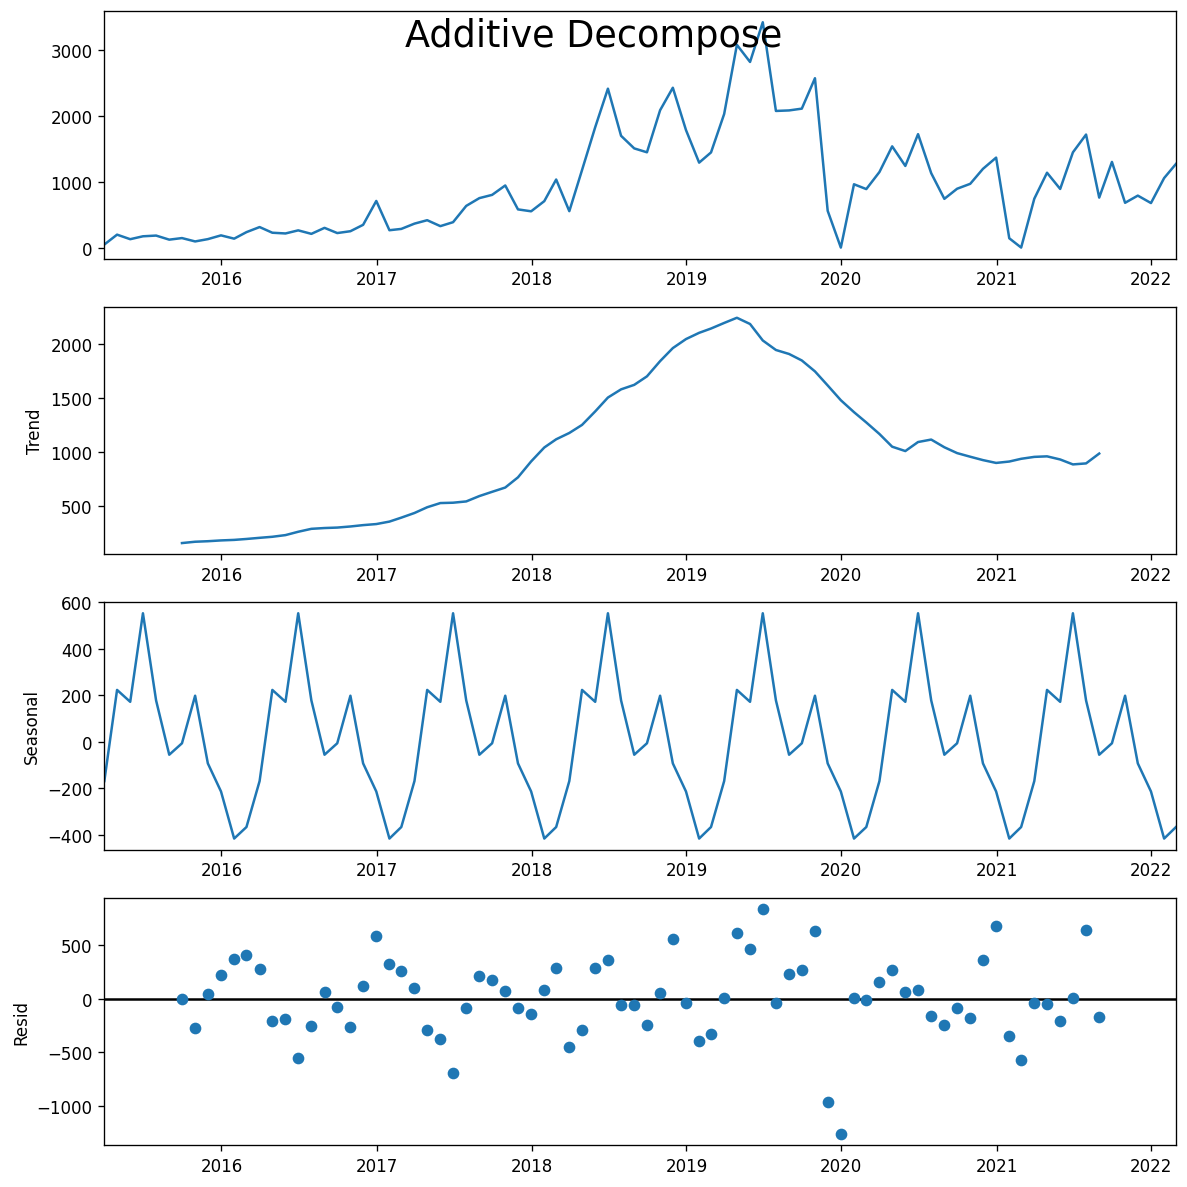

In [9]:
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)

We can see there is some seasonality here with what we're dealing with. Of course, since we resampled on a monthly basis, some of that may be artifical, but I'm inclined to say that's not the case. It looks like we see 3 distince spikes in comments. Those would be in about March, April, and November. The biggest spike appears to be in April. 

### Step 3) Detrending

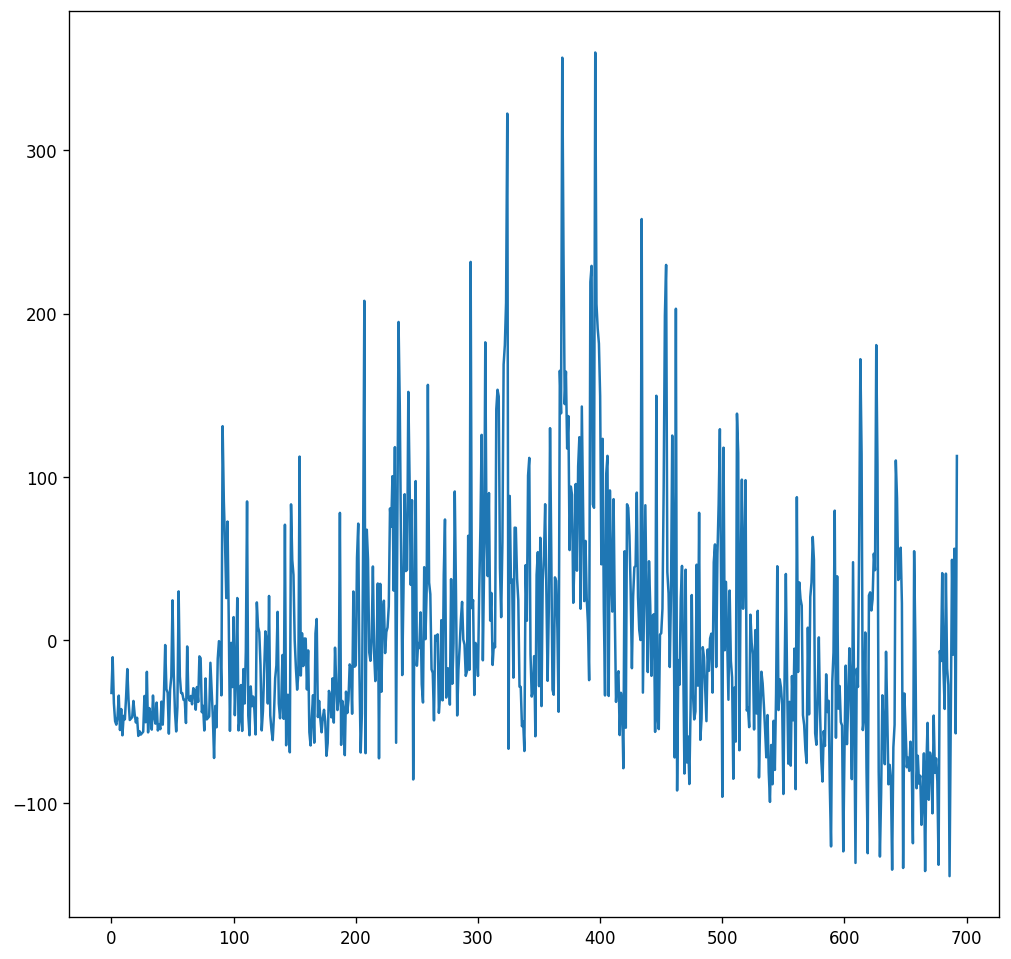

In [10]:
# let's use a simple linear regression to detrend this -> doesn't have to be super advanced here
from sklearn.linear_model import LinearRegression

X = [i for i in range(0, len(comment_periodicity))]
X = np.reshape(X, (len(X), 1))
y = comment_periodicity.values


model = LinearRegression()
model.fit(X, y)

trend = model.predict(X)
detrended = [y[i]-trend[i] for i in range(0, len(comment_periodicity))]

plt.plot(detrended)
plt.show()

We can see this isn't an amazing trend in that it has many negative values; obviously those aren't realistic. Let's go ahead and make a polynomial model to try to detrend the data that way.

In [11]:
from sklearn.preprocessing import PolynomialFeatures

In [12]:
poly = PolynomialFeatures(degree=10, include_bias=False)

In [13]:
poly_features = poly.fit_transform(X)

In [14]:
poly_reg_model = LinearRegression()

In [15]:
poly_reg_model.fit(poly_features, y)

LinearRegression()

In [16]:
y_predicted = poly_reg_model.predict(poly_features)

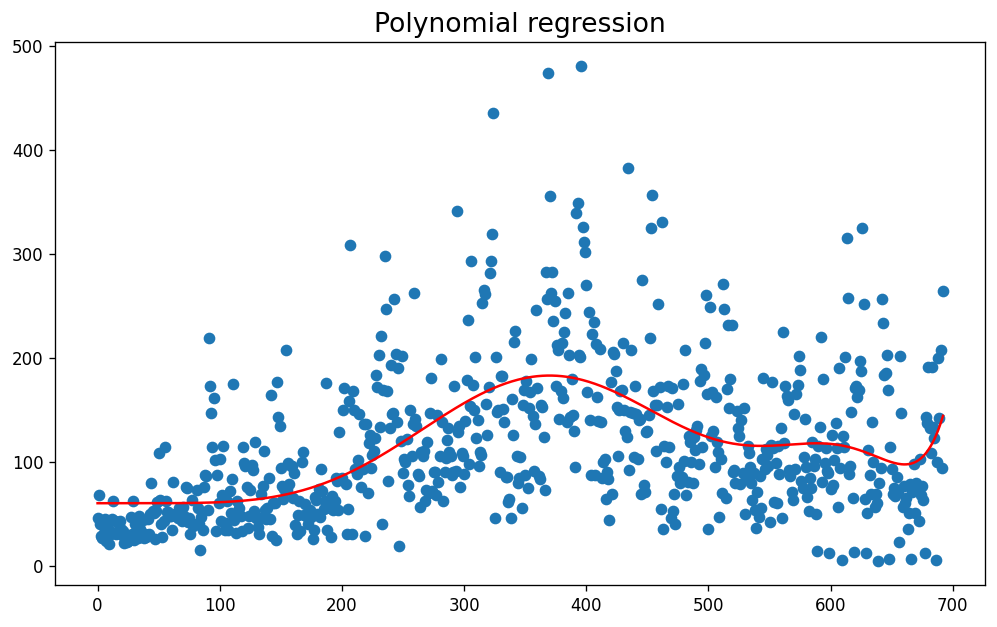

In [17]:
plt.figure(figsize=(10, 6))
plt.title("Polynomial regression", size=16)
plt.scatter(X, y)
plt.plot(X, y_predicted, c="red")
plt.show()

In [18]:
detrended2 = [y[i]-y_predicted[i] for i in range(0, len(comment_periodicity))]

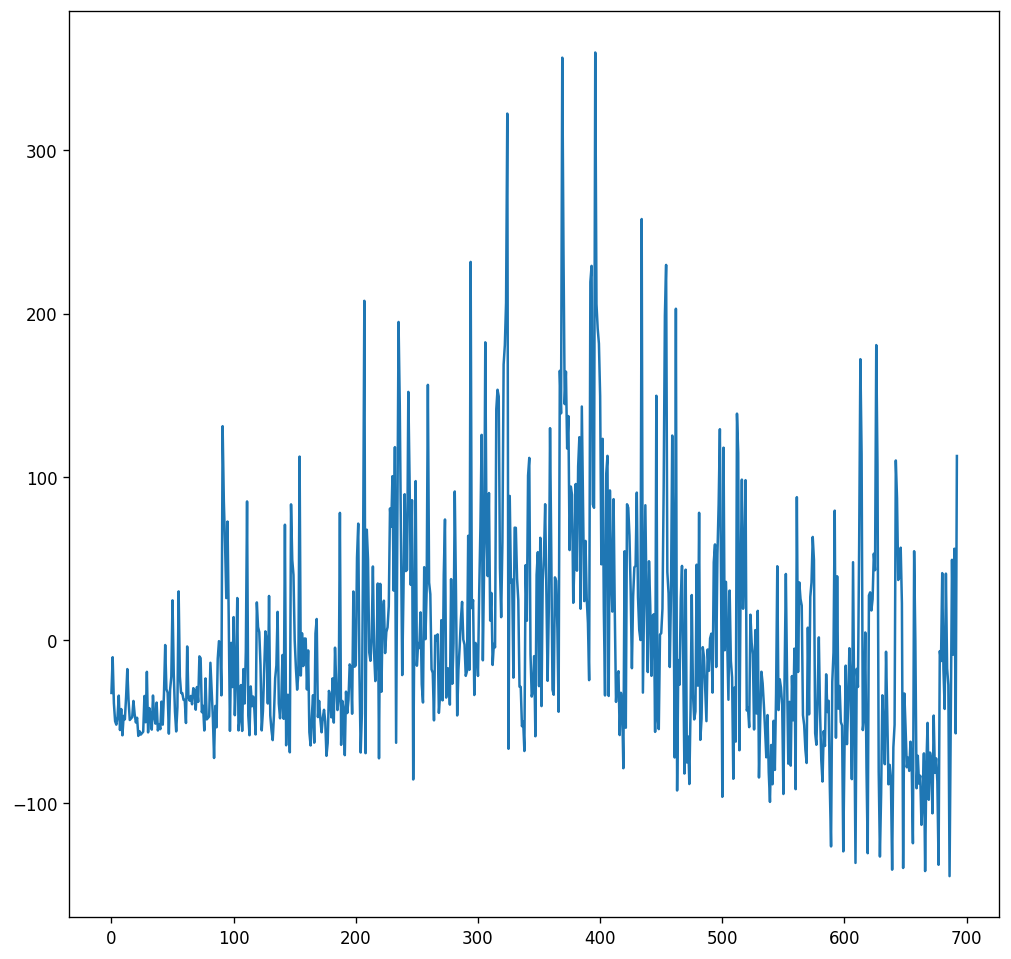

In [19]:
plt.plot(detrended)
plt.show()

It's still got a bunch of negative values...to me that indicates that no matter what, the detrending is being too aggressive for us to rely on here. Thus, I'm going to go ahead and correct it so that the lowest values are 0. 

In [20]:
detrended2 = [x[0] if x[0] > 0 else 0 for x in detrended2]

In [21]:
data["detrended_non_neg"] = detrended2 # adding the detrended data to the df as the tgt variable

In [23]:
data["detrended"] = detrended

In [24]:
data.to_json("book_chapters_w_NER_sent_readability_tgt_var.jl", orient="records", lines=True)